## 금 가격 예측을 위한 시계열 분석 모델 실습

**목표:** `neuralforecast`의 `cross_validation` 기능을 활용하여 ARIMA, RNN, LSTM, CNN, NHITS, NBEATS 모델의 1일 롤링 예측 성능을 효율적으로 평가하고 비교 분석합니다.

### 1. 라이브러리 설치

In [ ]:
!pip install neuralforecast statsforecast -q

### 2. 라이브러리 임포트

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import RNN, LSTM, NHITS, NBEATS, TCN
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

### 3. 데이터 준비

금 가격 데이터를 불러와 전처리 및 정규화를 수행합니다. `cross_validation` 함수는 내부적으로 데이터를 분할하므로, 전체 데이터를 사용합니다.

In [21]:
# 데이터 불러오기
url = 'https://raw.githubusercontent.com/safeai-snu/TimeSeriesAI/refs/heads/main/ch3/dataset/gold.csv'
df = pd.read_csv(url)

# 데이터 전처리
df = df.rename(columns={'Date': 'ds', 'Close': 'y'})
df['unique_id'] = 'gold'
df = df[['unique_id', 'ds', 'y']]

# 역정규화를 위해 원본 데이터 복사
df_unscaled = df.copy()

# 데이터 정규화
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df['y'].values.reshape(-1,1))

# 훈련/테스트 분할 비율 설정 (실제 분할은 cross_validation에서 수행)
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

### 4. 모델 정의 및 롤링 예측 (Cross Validation 활용)

`cross_validation` 함수를 사용하여 롤링 예측 백테스트를 수행합니다. `horizon=1`로 설정하고 `step_size=1`로 설정하여 매일 모델을 업데이트하며 다음 날을 예측합니다.

In [26]:
horizon = 5
input_size = 30 # 예측을 위해 30일 전 데이터까지 참고

# 신경망 모델 정의
neural_models = [
    RNN(h=horizon, input_size=input_size, encoder_hidden_size=50, max_steps=100),
    LSTM(h=horizon, input_size=input_size, encoder_hidden_size=50, max_steps=100),
    TCN(h=horizon, input_size=input_size, encoder_hidden_size=50, max_steps=100), ## CNN의 Time Series 특화 버전
    NBEATS(h=horizon, input_size=input_size, max_steps=100),
    NHITS(h=horizon, input_size=input_size, max_steps=100)
]

# NeuralForecast로 롤링 예측 수행
nf = NeuralForecast(models=neural_models, freq=1)
nf_preds_df = nf.cross_validation(df=df, test_size=test_size, step_size=1, n_windows=None)

# ARIMA 모델 정의 및 롤링 예측 수행
sf = StatsForecast(models=[AutoARIMA()], freq=1)
sf_preds_df = sf.cross_validation(df=df, h = horizon, test_size=test_size, step_size=1, n_windows=None)

# 예측 결과 병합
preds_df = pd.merge(nf_preds_df, sf_preds_df, on=['ds', 'unique_id', 'cutoff', 'y'])

Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | RNN           | 7.8 K  | train
4 | mlp_decoder  | MLP           | 6.7 K  | train
-------------------------------------------------------
14.4 K    Trainable params
0         Non-trainable params
14.4 K    Total params
0.058     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                 …

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 31.0 K | train
4 | mlp_decoder  | MLP           | 6.7 K  | train
-------------------------------------------------------
37.7 K    Trainable params
0         Non-trainable params
37.7 K    Total params
0.151     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                 …

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MAE                        | 0      | train
1 | padder_train    | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 20.4 K | train
4 | context_adapter | Linear                     | 155    | train
5 | mlp_decoder     | MLP                        | 6.7 K  | train
-----------------------------------------------------------------------
27.2 K    Trainable params
0         Non-trainable params
27.2 K    Total params
0.109     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                 …

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
385       Non-trainable params
2.4 M     Total params
9.765     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                 …


KeyboardInterrupt



In [23]:
preds_df = preds_df[preds_df['ds']-preds_df['cutoff']==1]

In [24]:
preds_df

,unique_id,ds,cutoff,RNN,LSTM,TCN,NBEATS,NHITS,y,AutoARIMA
0,gold,1032,1031,0.802803,0.805353,0.814816,0.812825,0.815883,0.864668,0.811498
5,gold,1033,1032,0.799347,0.804513,0.814322,0.869303,0.871855,0.873264,0.866609
10,gold,1034,1033,0.800840,0.804977,0.807327,0.877626,0.880395,0.822790,0.877603
15,gold,1035,1034,0.813007,0.813681,0.824303,0.827152,0.829487,0.828301,0.827443
20,gold,1036,1035,0.815122,0.819421,0.861126,0.832910,0.835481,0.742120,0.826636
...,...,...,...,...,...,...,...,...,...,...
1245,gold,1281,1280,0.690933,0.688602,0.667031,0.716247,0.718643,0.697157,0.710563
1250,gold,1282,1281,0.674818,0.679578,0.671898,0.704913,0.706920,0.690655,0.698504
1255,gold,1283,1282,0.669868,0.673205,0.674958,0.698370,0.700347,0.705532,0.688752
1260,gold,1284,1283,0.699086,0.686940,0.680534,0.713183,0.715172,0.716002,0.706082


### 5. 결과 시각화 및 평가

`cross_validation`을 통해 얻은 롤링 예측 결과를 시각화하고, MAE를 계산하여 모델별 성능을 비교합니다.

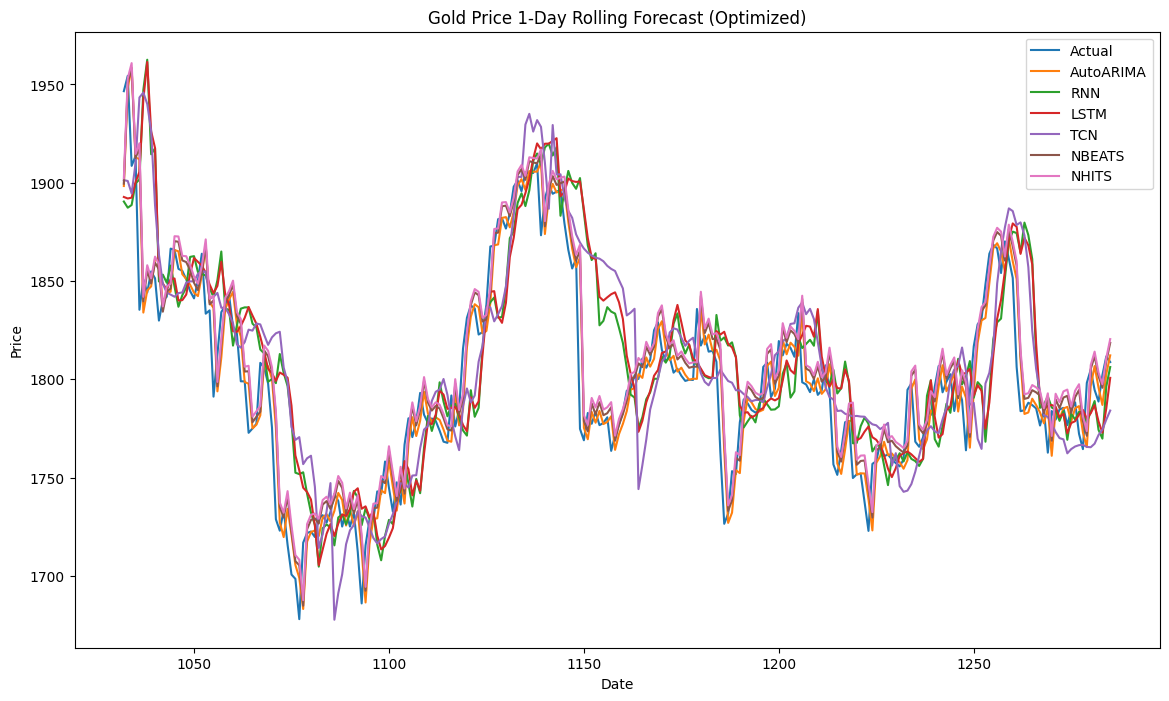

AutoARIMA MAE: 11.5876
RNN MAE: 27.0531
LSTM MAE: 27.5246
TCN MAE: 28.7998
NBEATS MAE: 12.8234
NHITS MAE: 13.8647


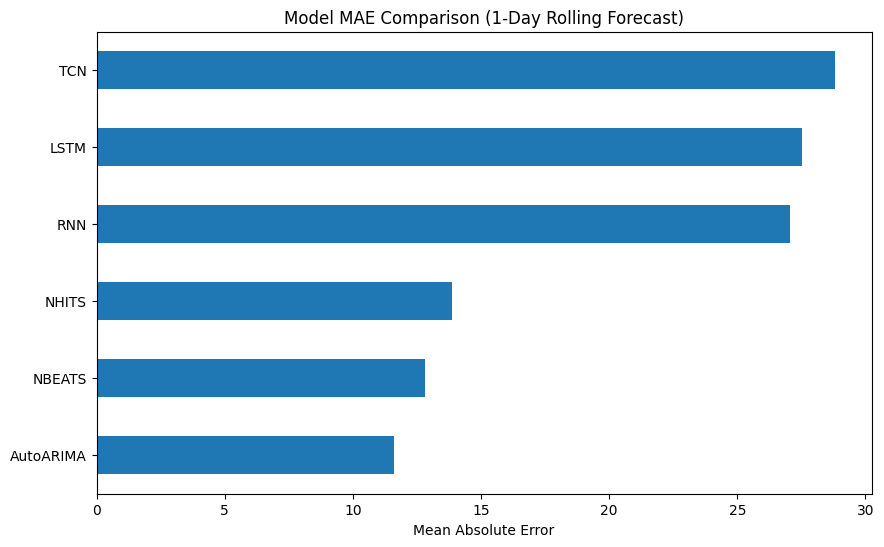

In [25]:
# 예측 결과 역정규화
for col in preds_df.columns:
    if col not in ['ds', 'unique_id', 'cutoff']:
        preds_df[col] = scaler.inverse_transform(preds_df[col].values.reshape(-1,1))

# 시각화를 위해 실제 값과 예측 값 분리
y_true_df = df_unscaled[train_size:]
y_preds_df = preds_df.set_index('ds')

# 시각화
plt.figure(figsize=(14, 8))
plt.plot(y_preds_df.index, y_preds_df['y'], label='Actual')
for model in ['AutoARIMA', 'RNN', 'LSTM', 'TCN', 'NBEATS', 'NHITS']:
    plt.plot(y_preds_df.index, y_preds_df[model], label=model)

plt.title('Gold Price 1-Day Rolling Forecast (Optimized)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# 성능 평가
mae_scores = {}
y_true = preds_df['y'].values

for model in ['AutoARIMA', 'RNN', 'LSTM', 'TCN', 'NBEATS', 'NHITS']:
    y_pred = preds_df[model].values
    mae = mean_absolute_error(y_true, y_pred)
    mae_scores[model] = mae
    print(f'{model} MAE: {mae:.4f}')
    
# 성능 비교 시각화
plt.figure(figsize=(10, 6))
pd.Series(mae_scores).sort_values().plot(kind='barh')
plt.title('Model MAE Comparison (1-Day Rolling Forecast)')
plt.xlabel('Mean Absolute Error')
plt.show()

### 6. 결론

`cross_validation` 함수를 사용하면 복잡한 코드 없이도 효율적으로 롤링 예측을 수행하고 모델의 성능을 평가할 수 있습니다. 시각화된 결과와 MAE 점수를 통해 각 모델이 1일 예측 시나리오에서 어떤 성능을 보이는지 명확하게 비교할 수 있습니다.